# Distortion summary
* 0) Import libraries
* 1) Load csv file with distortion and split them per sector to enable correlation
* 2) Draw distortion as function of other distortions
* 3) Draw Distortion as function of the TRD flux
* 4)  Load fitter and fit distortion in regions as function of other distortions

# 0) Import libraries

In [1]:
from distortionStudy import *
from TTreeHnInteractive.TTreeHnBrowser import *
from TTreeHnInteractive.bokehTools import *
import matplotlib.pyplot as plt
from MLpipeline.NDFunctionInterface import  DataContainer, Fitter
output_notebook()
p3 = figure(plot_width=400, plot_height=250, title="template")

Welcome to JupyROOT 6.13/03


Using TensorFlow backend.


Loading BokehJS ...

# 1) Load csv file with distortion and split them per sector to enable correlation

In [2]:
input=os.path.expandvars("$NOTESData/JIRA/ATO-336/DistortionsTimeSeries/distortionAll.csv")
df=readDataFrame(input)
dfsplit=splitDistortionFrame(df)
print("load csv file", input, df.shape, dfsplit.shape)
dfsplit.head(3)
dfsplit=dfsplit.query("iz2x>2 & meanTRDCurrent<0.3  & abs(invTRDCurrentNorm)<0.05 & gascompH2O>0")
dfsplit=SetAlias(dfsplit,"H2O","gascompH2O/100.")

('load csv file', '/data/NOTESdata/alice-tpc-notes//JIRA/ATO-336/DistortionsTimeSeries/distortionAll.csv', (100000, 70), (5555, 92))


# 2)  Draw distortion as function of other distortions

In [3]:
pAll=drawColzArray(dfsplit,"time>0","drphiMean","drphiSector2:drphiSector4:drphiSector6:drphiSector7:drphiSector9:drphiSector16:drphiSector20:drphiSector30","H2O",p3,ncols=3, commonX=1)

# 3) Draw Distortion as function of the TRD flux

In [4]:
pAll=drawColzArray(dfsplit,"time>0","meanTRDCurrent","drphiSector2:drphiSector4:drphiSector6:drphiSector7:drphiSector9:drphiSector16:drphiSector20:drphiSector30","H2O",p3,ncols=3, commonX=1)

# 4)  Load fitter and fit distortion as function of other distortions

In [ ]:
varFit='drphiSector2'
variableX= ['drphiMean',"H2O", "iz2x",'bz',"deltaTRDCurrentNorm"]
dataContainer = DataContainer(dfsplit, variableX, varFit, [500,500])
fitter = Fitter(dataContainer)
#fitter.Register_Method('KM200','KerasModel', 'Regressor', layout = [200, 10, 10],  epochs=100, dropout=0.1, l1=0.1)
fitter.Register_Method('KNN','KNeighbors', 'Regressor')
fitter.Register_Method('RF','RandomForest', 'Regressor', n_estimators=100, max_depth=10)
fitter.Register_Method('RF200','RandomForest', 'Regressor', n_estimators=200, max_depth=10)
fitter.Register_Method('KM','KerasModel', 'Regressor', layout = [50, 50, 50], epochs=300, dropout=0.4)
fitter.Fit()
test=dataContainer.Test_sample
#fitter.Compress('KM')
for method in ['RF', 'KNN', 'RF200', 'KM']: 
    test = fitter.AppendOtherPandas(method,test)

In [6]:
fitter.printImportance()

iz2x 0.0022450290908524566
deltaTRDCurrentNorm 0.010344066838094391
bz 0.01675085479441372
H2O 0.037082951319188456
drphiMean 0.9335770979574509
iz2x 0.002331455056180996
bz 0.0051472013257199845
deltaTRDCurrentNorm 0.010239866612709328
H2O 0.028730820679373402
drphiMean 0.953550656326016


## 4.1)  Bokeh visualization of regression results

In [7]:
p3 = figure(plot_width=600, plot_height=350, title="drphiSector")
plot=drawColzArray(test," abs (invTRDCurrentNorm)<0.05&year<2017", varFit,"RF:RF200:KNN:KM","H2O",p3,ncols=2)
plot=drawColzArray(test," abs (invTRDCurrentNorm)<0.05&year<2017", "RF","RF:RF200:KNN:KM","H2O",p3,ncols=2)

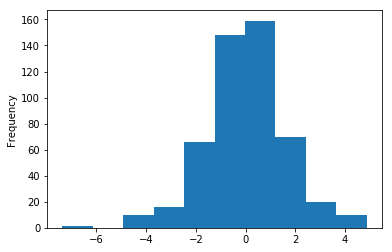

In [8]:
clf=fitter.Models[2].model
fitter.AppendStatPandas("RF",test)
fitter.AppendStatPandas("RF200",test)
test=SetAlias(test,"pullRF_2","(drphiSector2-RFMedian)/RFRMS")
test=SetAlias(test,"pullRF200_2","(drphiSector2-RF200Median)/RF200RMS")
drawColzArray(test,"abs(invTRDCurrentNorm)<0.05&year<2017", "RF","RFMedian","H2O",p3,ncols=3)

test['pullRF_2'].plot.hist()

# TRD curent model

In [9]:
#variableX= ['meanTRDCurrent','deltaTRDCurrent','bz','bckg0Mean', 'bckg1Mean', 'bckg2Mean',"gascompH2O"]
variableX= ['meanTRDCurrent','deltaTRDCurrentNorm','bz',"H2O","iz2x", "bsign","gascompCO2"]
#variableX= ['meanTRDCurrent','deltaTRDCurrentNorm','bz',"iz2x", "bsign"]
x = DataContainer(dfsplit, variableX, ['drphiSector4'], [500,500])
fitter = Fitter(x)
fitter.Register_Method('KNN','KNeighbors', 'Regressor')
fitter.Register_Method('RF','RandomForest', 'Regressor', n_estimators=100, max_depth=10)
fitter.Register_Method('RF200','RandomForest', 'Regressor', n_estimators=200, max_depth=10)
#list(variableX)
fitter.Fit()
for method in ['RF', 'KNN', 'RF200']: 
    dfsplit = fitter.AppendOtherPandas(method,dfsplit)

In [10]:
fitter.AppendStatPandas("RF",dfsplit)
fitter.AppendStatPandas("RF200",dfsplit)
dfsplit=SetAlias(dfsplit,"pullRF","(drphiSector2-RFMedian)/RFRMS")
p = figure(plot_width=500, plot_height=300, title="drphiSector2")
plot=drawColzArray(dfsplit," trdMeanMedianL0<1 & abs (invTRDCurrentNorm)<0.05&year<2017", "meanTRDCurrent","drphiSector4:RF200","H2O",p,commonX=1,commonY=1)
plot=drawColzArray(dfsplit," trdMeanMedianL0<1 & abs (invTRDCurrentNorm)<0.05&year<2017", "time","pullRF","H2O",p,commonX=1,commonY=1)
drawColzArray?

Signature: drawColzArray(dataFrame, query, varX, varY, varColor, p=None, **options)
Docstring:
drawing example - functionality like the tree->Draw colz

:param dataFrame:   data frame
:param query:
:param varX:        x query
:param varY:        y query array of queries
:param varColor:    z query
:param p:           figure template TODO - check if some easier way to pass parameters -CSS string ?
:return:
TODO  use other options if specified: size file and line color - p.circle(x, factors, size=15, fill_color="orange", line_color="green", line_width=3)
File:      ~/github/RootInteractive/TTreeHnInteractive/bokehTools.py
Type:      function


In [11]:
fitter.printImportance()


iz2x 0.008514460451718154
bz 0.010280924517856931
bsign 0.01844987871954259
gascompCO2 0.061841728325572005
deltaTRDCurrentNorm 0.07605928475311394
meanTRDCurrent 0.34840636749911674
H2O 0.47644735573307984
iz2x 0.009243458582600433
bz 0.010341521406253818
bsign 0.016240916220997978
gascompCO2 0.05512527887075826
deltaTRDCurrentNorm 0.07779765802832962
H2O 0.40310269230727774
meanTRDCurrent 0.4281484745837817


## Playing with pandas - TO BE DELETED later

In [12]:
list(dfsplit)

['year',
 'period',
 'fill',
 'run',
 'time',
 'timeStart',
 'timeEnd',
 'bsign',
 'bz',
 'ir',
 'isec',
 'sector',
 'iz2x',
 'isIROC',
 'drphiQ95',
 'drphiQ96',
 'drphiQ97',
 'drphiQ98',
 'drphiQ99',
 'drphiQ100',
 'drphiSmoothedQ95',
 'drphiSmoothedQ96',
 'drphiSmoothedQ97',
 'drphiSmoothedQ98',
 'drphiSmoothedQ99',
 'drphiSmoothedQ100',
 'drQ95',
 'drQ96',
 'drQ97',
 'drQ98',
 'drQ99',
 'drQ100',
 'drSmoothedQ95',
 'drSmoothedQ96',
 'drSmoothedQ97',
 'drSmoothedQ98',
 'drSmoothedQ99',
 'drSmoothedQ100',
 'trdMeanMedianL0',
 'trdIntMedianL0',
 'trdMeanMedianL1',
 'trdIntMedianL1',
 'trdMeanMedianL2',
 'trdIntMedianL2',
 'trdMeanMedianL3',
 'trdIntMedianL3',
 'trdMeanMedianL4',
 'trdIntMedianL4',
 'trdMeanMedianL5',
 'trdIntMedianL5',
 'tpcHV',
 'vcIA',
 'vcIC',
 'vcOA',
 'vcOC',
 'vggIA',
 'vggIC',
 'vggOA',
 'vggOC',
 'dVggIA',
 'dVggIC',
 'dVggOA',
 'dVggOC',
 'gascompCO2',
 'gascompAr',
 'gascompH2O',
 'bckg0Mean',
 'bckg1Mean',
 'bckg2Mean',
 'eventsPerSecTPC',
 'drphiSector2',
 